In [1]:
import numpy as np
from astropy import units as u, constants as const
from matplotlib import pyplot as plt
from scipy.stats import beta
from scipy.special import beta as betafct
from numba import jit, jitclass
from scipy import interpolate
from scipy.interpolate import interp1d
import logging
import sys
import os
sys.path.insert(1, '/home/jsipple/one_d_spherical_collapse/one-d-spherical-collapse-of-fuzzy-dark-matter/src')
import importlib
import simulation_strategies, collapse, plotting, utils, analtyic_formulas
importlib.reload(simulation_strategies)
importlib.reload(collapse)
importlib.reload(plotting)
importlib.reload(utils)
importlib.reload(analtyic_formulas)
from simulation_strategies import *
from collapse import *
from plotting import *
from utils import *
from analtyic_formulas import *
import cProfile
import pstats

In [2]:
# Default plotting settings
def my_mpl():
    plt.rc('font', family='serif', size=20)
    plt.rc('axes', grid=True)
    plt.rc('lines', lw=3)
    ts = 8
    plt.rc('xtick.minor', size=ts-2)
    plt.rc('ytick.minor', size=ts-2)
    plt.rc('xtick.major', size=ts)
    plt.rc('ytick.major', size=ts)
    plt.rc('figure', figsize=[12, 9])
my_mpl()
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [3]:
t_i = 1
G = 1
rho_H = 1/(6*np.pi*G*t_i**2)
ss = SelfSimilarSolution(t_i, G, rho_H)

In [4]:
def compute_r0_min(r_min, r_max, N):
    """
    Compute r0_min such that the spacing dR in np.linspace(r0_min, r_max, N)
    satisfies dR = r0_min - r_min. That is, the inner edge of the innermost shell is at r_min.
    
    Parameters:
    - r_min (float): The minimum radius.
    - r_max (float): The maximum radius.
    - N (int): Number of points.
    
    Returns:
    - float: The computed r0_min.
    """
    return (r_max + r_min * (N - 1)) / N
r_min = 0.5
r_max = 1
N = 2
r0_min = compute_r0_min(r_min, r_max, N)
print(r0_min)

0.75


In [5]:
# Cosmological Parameters
delta_i = 1e-2
density_strategy = 'background_plus_tophat'
tophat_radius = 1
m_pert = rho_H * delta_i * 4/3 * np.pi * tophat_radius**3
H = 2/(3*t_i)

# General Simulation Parameters
N = 1
r_max = 1
t_max = 4.2*ss.t_ta(r_max, m_pert, H)
stepper = 'velocity_verlet'
safety, dt_min, timescale_strategy, = 1e-5, 1e-9, 'dyn'
save_dt, save_strategy = 1e-3, 'vflip'
r_min_strategy = 'reflect'

# Shell Definitions
# Shell's DONT go all the way to the center, there is a point mass
m_enc_strategy = 'const_inclusive'
shell_volume_strategy = 'inner_not_zero'
r0_strategy = 'r0min_start_equal'
r_min = 0.1
r0_min = compute_r0_min(r_min, r_max, N)
# The point mass should be all of the mass within the inner edge of the innermost shell
# r0_min should be chosen such that the inner edge of the innermost shell is at r_min <= tophat_radius, else change this line
point_mass = 4/3 * np.pi * r_min**3 * rho_H * (1+delta_i)

# Angular Momementum, Softening, and Thickness
# ZERO FOR ALL THREE
j_coef, ang_mom_strategy, r_ta_strategy = 0, 'zero', 'tophat_pert_r_ta'
softlen, thickness = 0, 0
energy_strategy, accel_strategy = 'kin_grav_rot', 'soft_all'
# Other Cases Go Here

# Miscellaneous Parameters
save_filename = None
deque_size = 1
show_progress = True

config = {
    'shell_volume_strategy': shell_volume_strategy,
    'point_mass': point_mass,
    'softlen': softlen,
    'density_strategy': density_strategy,
    'tophat_radius': tophat_radius,
    'initial_radius_strategy': r0_strategy,
    'r0_min': r0_min,
    'rho_bar': rho_H,
    'safety_factor': safety,
    'thickness_coef': thickness,
    'j_coef': j_coef,
    'ang_mom_strategy': ang_mom_strategy,
    'r_ta_strategy': r_ta_strategy,
    'energy_strategy': energy_strategy,
    'accel_strategy': accel_strategy,
    't_max': t_max,
    'dt_min': dt_min,
    'N': N,
    'r_min': r_min,
    'r_min_strategy': r_min_strategy,
    'H': H,
    'r_max': r_max,
    'm_pert': m_pert, 
    'stepper_strategy': stepper,
    'timescale_strategy': timescale_strategy,
    'm_enc_strategy': m_enc_strategy,
    'save_strategy': save_strategy,
    'save_dt': save_dt,
    'deque_size': deque_size,
    'save_filename': save_filename,
    'show_progress': show_progress,
}

In [6]:
x = SphericalCollapse(config)
profile = False
if profile:
    # Profile the run method
    profiler = cProfile.Profile()
    profiler.enable()
    results = x.run()
    profiler.disable()

    # Print the profiling results
    stats = pstats.Stats(profiler).sort_stats('cumulative')
    stats.print_stats(20)  # Print top 20 time-consuming functions
else:
    results = x.run()

2025-01-09 13:21:06,008 - collapse - INFO - Simulation setup complete


/home/jsipple/one_d_spherical_collapse/one-d-spherical-collapse-of-fuzzy-dark-matter/src/collapse.py:376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return {key: np.array(value) for key, value in results.items()}


<Figure size 864x648 with 0 Axes>

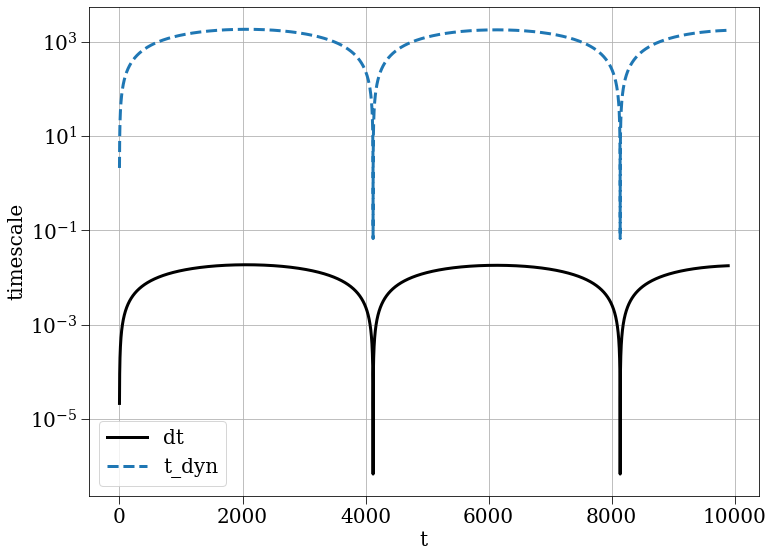

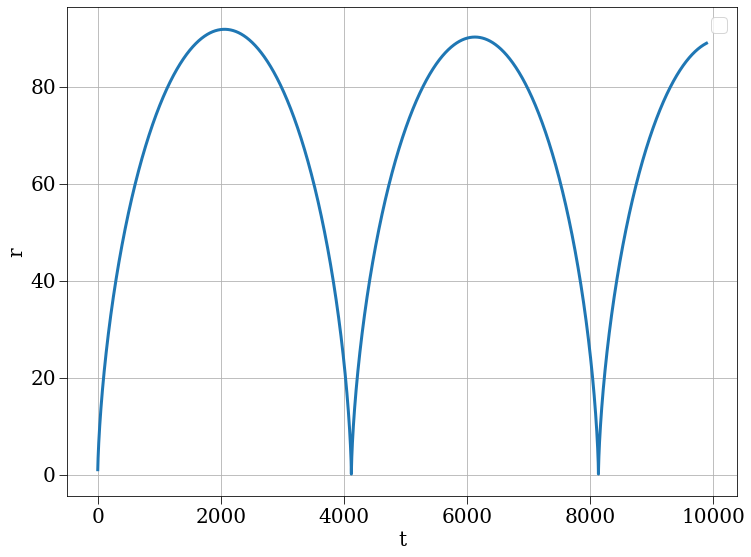

<Figure size 864x648 with 0 Axes>

In [7]:
t, dt, t_dyn = results['t'], results['dt'], results['t_dyn']
plt.plot(t, dt, ls='-', color='k', label='dt')
plt.plot(t, t_dyn, ls='--', label='t_dyn')
plt.yscale('log')
plt.xlabel('t')
plt.ylabel('timescale')
plt.legend()
plt.figure()

for idx in range(0, N):
    t, r = results['t'], results['r'][:, idx]
    plt.plot(t, r, color=f'C{idx}', ls='-')
    #plt.fill_between(t, r, r-thickness, color=f'C{idx}', alpha=0.3)

plt.xlabel('t')
plt.ylabel('r')
plt.legend()
plt.figure()
# for idx in range(0, N):
#     t, r = results['t'], results['r'][:, idx]
#     tta, rta = ss.t_ta(r[0], m_pert, H), ss.r_ta(r[0], m_pert)
#     plt.plot((t+t_i)/tta, r/rta, color=f'C{idx}')
# plt.plot(t_tta, r_rta, 'k-', lw=1)
# plt.xlim(0, 3)
# plt.ylim(0,)
# plt.xlabel(r'$t/t_{ta}$')
# plt.ylabel(r'$r/r_{ta}$')
# plt.legend()


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


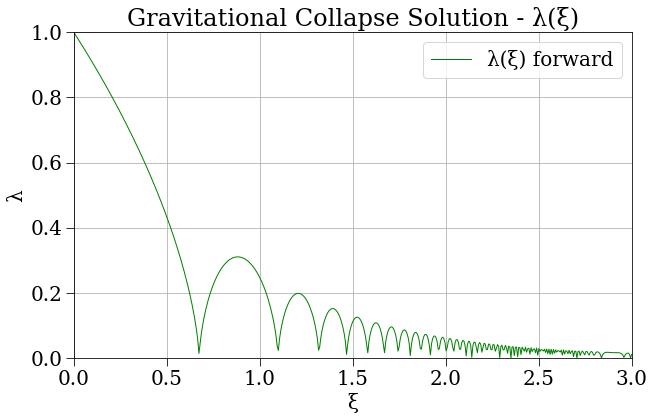

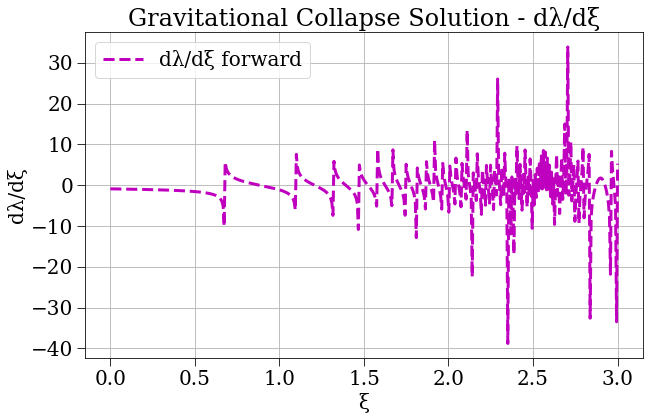


Solution statistics:
Forward integration steps: 5839820
Final forward λ value: 0.012113


In [52]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


def gravitational_system(xi, y):
    """
    Convert 2nd order ODE to system of 1st order ODEs
    y[0] = λ
    y[1] = dλ/dξ
    """
    lambda_val, dlambda = y
    
    # Ensure lambda stays positive
    #lambda_val = np.maximum(lambda_val, 1e-10)
    
    # Original equation: d²λ/dξ² + (7/9)(dλ/dξ) + 8/81 = -(2/9)M(λ)/λ²
    j_squared = 1e-4
    d2lambda = -(7/9) * dlambda - 8/81 - (2/9) * ss.m_lambda(lambda_val, H) / (lambda_val**2) + j_squared / lambda_val**3
    
    return [dlambda, d2lambda]


# Initial conditions at xi=0
xi_0 = 0
lambda_0 = 1.0
dlambda_0 = -8/9
y0 = [lambda_0, dlambda_0]

method = 'DOP853'
tol = 1e-16

backwards = False  # Flag to control backward integration and plotting

# Forward integration (positive time direction)
solution_forward = solve_ivp(
    gravitational_system,
    [0, 3],  # Forward from 0 to 3
    y0,
    method=method,
    rtol=tol,
    atol=tol,
    dense_output=True,
    events=lambda t, y: y[1]
)

# Generate smooth output for forward solution
xi_forward = np.linspace(0, 3, 500)
y_forward = solution_forward.sol(xi_forward)

# Plot lambda for forward direction
plt.figure(figsize=(10, 6))
plt.plot(xi_forward, y_forward[0], 'g-', label='λ(ξ) forward', lw=1)
plt.grid(True)
plt.xlabel('ξ')
plt.ylabel('λ')
plt.title('Gravitational Collapse Solution - λ(ξ)')
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 3)

# Plot derivative of lambda for forward direction
plt.figure(figsize=(10, 6))
plt.plot(xi_forward, y_forward[1], 'm--', label='dλ/dξ forward')
plt.grid(True)
plt.xlabel('ξ')
plt.ylabel('dλ/dξ')
plt.title('Gravitational Collapse Solution - dλ/dξ')
plt.legend()
plt.show()

# Print some key values for forward direction
print("\nSolution statistics:")
print(f"Forward integration steps: {solution_forward.nfev}")
print(f"Final forward λ value: {y_forward[0][-1]:.6f}")

if backwards:
    # Backward integration (negative time direction)
    solution_backward = solve_ivp(
        gravitational_system,
        [0, -5],  # Backward from 0 to -5
        y0,
        method=method,
        rtol=tol,
        atol=tol,
        dense_output=True
    )

    # Generate smooth output for backward solution
    xi_backward = np.linspace(-5, 0, 500)
    y_backward = solution_backward.sol(xi_backward)

    # Plot lambda
    plt.figure(figsize=(10, 6))
    plt.plot(xi_backward, y_backward[0], 'b-', label='λ(ξ) backward', lw=1)
    plt.grid(True)
    plt.xlabel('ξ')
    plt.ylabel('λ')
    plt.title('Gravitational Collapse Solution - λ(ξ)')
    plt.legend()
    plt.ylim(0, 1)
    plt.xlim(-5, 0)

    # Plot derivative of lambda
    plt.figure(figsize=(10, 6))
    plt.plot(xi_backward, y_backward[1], 'r--', label='dλ/dξ backward')
    plt.grid(True)
    plt.xlabel('ξ')
    plt.ylabel('dλ/dξ')
    plt.title('Gravitational Collapse Solution - dλ/dξ')
    plt.legend()
    plt.show()

    # Print some key values
    print("\nSolution statistics:")
    print(f"Backward integration steps: {solution_backward.nfev}")
    print(f"Final backward λ value: {y_backward[0][0]:.6f}")

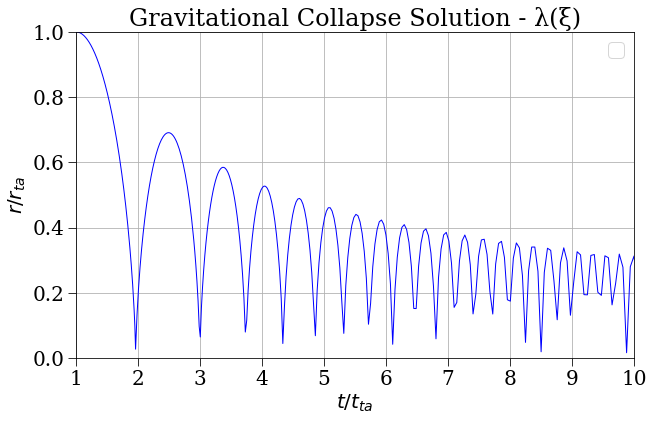

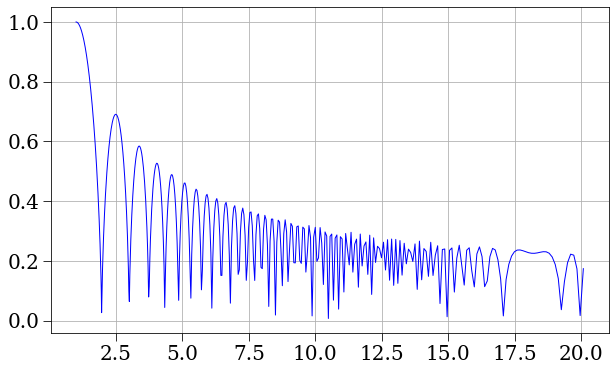

In [53]:
plt.figure(figsize=(10, 6))
t_tta = np.exp(xi_forward)
r_rta = y_forward[0]*np.exp((8/9)*xi_forward)
plt.plot(t_tta, r_rta, 'b-', lw=1)
plt.xlabel(r'$t/t_{ta}$')
plt.ylabel(r'$r/r_{ta}$')
plt.title('Gravitational Collapse Solution - λ(ξ)')
plt.legend()
plt.ylim(0,1)
plt.xlim(1, 10)
plt.figure(figsize=(10, 6))
plt.plot(t_tta, r_rta, 'b-', lw=1)